In [31]:
import numpy as np
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from __future__ import annotations
import os
import logging
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import time

import torch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

# https://python.langchain.com/en/latest/modules/indexes/document_loaders/examples/excel.html?highlight=xlsx#microsoft-excel
from langchain.document_loaders import (
    CSVLoader,
    PDFMinerLoader,
    TextLoader,
    UnstructuredExcelLoader,
    Docx2txtLoader,
)

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma, FAISS

In [12]:
import os
INGEST_THREADS = os.cpu_count() or 8
def load_single_document(file_path: str) -> Document:
    # Loads a single document from a file path
    file_extension = os.path.splitext(file_path)[1]
    loader_class = DOCUMENT_MAP.get(file_extension)
    if loader_class == TextLoader:
        loader = TextLoader(file_path, encoding="utf-8")
    elif loader_class:
        loader = loader_class(file_path)
    else:
        raise ValueError("Document type is undefined")
    return loader.load()[0]
DOCUMENT_MAP = {
    ".txt": TextLoader,
    ".md": TextLoader,
    ".pdf": PDFMinerLoader,
    ".csv": CSVLoader,
    ".xls": UnstructuredExcelLoader,
    ".xlsx": UnstructuredExcelLoader,
    ".docx": Docx2txtLoader,
    ".doc": Docx2txtLoader,
}
def load_document_batch(filepaths):
    logging.info("Loading document batch")
    # create a thread pool
    with ThreadPoolExecutor(len(filepaths)) as exe:
        # load files
        futures = [exe.submit(load_single_document, name) for name in filepaths]
        # collect data
        data_list = [future.result() for future in futures]
        # return data and file paths
        return (data_list, filepaths)
def loadDocuments(
    source_dir: str, chunk_size=1000, chunk_overlap=200
) -> list[Document]:
    # Loads all documents from the source documents directory, including nested folders
    paths = []
    for root, _, files in os.walk(source_dir):
        for file_name in files:
            file_extension = os.path.splitext(file_name)[1]
            source_file_path = os.path.join(root, file_name)
            if file_extension in DOCUMENT_MAP.keys():
                paths.append(source_file_path)

    # Have at least one worker and at most INGEST_THREADS workers
    n_workers = min(INGEST_THREADS, max(len(paths), 1))
    # chunksize = round(len(paths) / n_workers)
    chunksize = max(round(len(paths) / n_workers), 1)
    docs = []
    with ProcessPoolExecutor(n_workers) as executor:
        futures = []
        # split the load operations into chunks
        for i in range(0, len(paths), chunksize):
            # select a chunk of filenames
            filepaths = paths[i : (i + chunksize)]
            # submit the task
            future = executor.submit(load_document_batch, filepaths)
            futures.append(future)
        # process all results
        for future in as_completed(futures):
            # open the file and load the data
            contents, _ = future.result()
            docs.extend(contents)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    documents: list[Document]
    documents = text_splitter.split_documents(docs)
    # documents = char_data_splitter(docs, chunk_size, chunk_overlap)
    return documents


In [13]:
endl = "\n"

In [14]:
#load_dotenv()
import re
# root_dir = "."
# sys.path.append(root_dir)  # if import module in this project error
if os.name != "nt":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
# %% [markdown]
###**setup var**

#%%
#chunk_size = 2000
# chunk_overlap = 200
# embedding_algorithm = "faiss"
# source_directory = f"{root_dir}/ir-service/docs"
# persist_directory = f"{root_dir}/ir-service/tmp/embeddings/{embedding_algorithm}"
# print(root_dir)
# print(persist_directory)

# Original mapper dictionary
mapper = {
    "law_doc-84-89.txt": "761/2566",
    "law_doc-44-46.txt": "1301/2566",
    "law_doc-54-57.txt": "1225/2566",
    "law_doc-12-13.txt": "2525/2566",
    "law_doc-40-43.txt": "1305/2566",
    "law_doc-14-15.txt": "2085/2566",
    "law_doc-64-69.txt": "1090/2566",
    "law_doc-1-5.txt": "2610/2566",
    "law_doc-78-81.txt": "882/2566",
    "law_doc-82-83.txt": "835/2566",
    "law_doc-35-39.txt": "1306/2566",
    "law_doc-16-20.txt": "1574/2566",
    "law_doc-32-34.txt": "1373/2566",
    "law_doc-74-77.txt": "934/2566",
    "law_doc-6-11.txt": "2609/2566",
    "law_doc-90-92.txt": "756/2566",
    "law_doc-47-53.txt": "1300/2566",
    "law_doc-58-63.txt": "1101/2566",
    "law_doc-70-73.txt": "1003/2566",
    "law_doc-21-31.txt": "1542/2566",
}

# Reverse the mapping and format it
mapper_reverse = {f"คดี {case}": filename for filename, case in mapper.items()}

endl = "\n"
# print(root_dir)
exclude_pattern = re.compile(r"[^ก-๙]+")  # |[^0-9a-zA-Z]+

In [15]:
import sys
root_dir = os.path.dirname(os.getcwd())
# sys.path.append(os.path.join(root_dir, 'deployment/ir-trt-service'))

In [16]:
contents = None
documents_specific = None
documents_general = None
documents = None


if contents is None:
    with open("/home/shanwibo/Capstone-TamTanai/notebooks/specific_case_knowledge.txt", "r", encoding="utf-8") as f:
        content = f.read()
    contents = content.split("\n\n")

    if documents_specific is None:
        documents_specific = [
            Document(
                page_content=f"{endl.join(c.split(endl)[1:])}",
                metadata={
                    "source": f"docs/{mapper_reverse[c.split(endl)[0]]}",
                    "category": "specific",
                },
            )
            for c in contents
        ]
if documents_general is None:
    # documents_general = loadDocuments(
    #         source_dir=f"/home/shanwibo/Capstone-TamTanai/asset/documentation", chunk_size=10e14, chunk_overlap=0
    #     )
    documents_general = loadDocuments(
            source_dir=f"/home/shanwibo/Capstone-TamTanai/asset/documentation", chunk_size=10e14, chunk_overlap=0
        )
    for i in range(len(documents_general)):
        documents_general[i].metadata["source"] = (
                documents_general[i].metadata["source"].replace(f"{root_dir}/", "")
            )
        documents_general[i].metadata["category"] = "general"
if documents is None:
    documents = documents_general + documents_specific

In [17]:
documents_text = []
for i in range (len(documents)) :
    documents_text.append(documents[i].page_content)

In [18]:
tokens_list = []
for i in range (len(documents_text)) :
    tokens_list.append(word_tokenize(documents_text[i], engine="newmm", keep_whitespace=False))

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
tokens_list_j = [','.join(tkn) for tkn in tokens_list]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(tokens_list_j)

In [20]:
from collections import defaultdict #Average TF

# Your list of lists representing different documents
_documents = tokens_list

# Initialize a dictionary to store total term frequency for each word
total_tf = defaultdict(float)

# Initialize a dictionary to store average term frequency for each word
average_tf = {}

# Iterate through each document to calculate term frequency of each word
for doc in _documents:
    for word in set(doc):  # Use set to avoid counting the same word multiple times in a document
        total_tf[word] += doc.count(word) / len(doc)

# Calculate the average term frequency for each word
for word in total_tf:
    average_tf[word] = total_tf[word] / len(_documents)

print(average_tf)

{'สอดคล้องกัน': 1.955824100119612e-06, 'ความเป็นมนุษย์': 5.642520164796453e-06, 'จำนวนมาก': 1.5175799497350723e-05, 'พิมพ์ลายนิ้วมือ': 1.930840888970841e-06, 'เพราะ': 0.0004850446168015948, 'รู้เท่าไม่ถึงการณ์': 1.497283926956501e-06, 'อื่น': 0.0031105600022738027, 'ภาระ': 4.748191045459473e-05, 'รุนแรง': 9.584656182921645e-06, 'รัฐมนตรี': 0.0010427220299718137, 'แล้ว': 0.003285998315737583, 'ในกรณีที่': 0.0020678630064883794, 'ประวัติ': 2.3513547613314954e-05, 'สอดคล้อง': 5.985008185523279e-05, 'มีทาง': 6.864913596498327e-06, 'กับ': 0.0020353887130166158, 'ตุลาคม': 5.563613555049486e-05, 'ร้อย': 0.00015998851914324406, 'อำนาจ': 0.000446375412772819, 'เริ่ม': 0.000180649962787013, 'นำ': 0.001935026399782741, 'ไทย': 0.0004046019727191459, 'สมควร': 0.00047337781766450536, 'เงิน': 0.0023703927938035128, 'วิธีการ': 0.0010067680943595108, 'ประกอบ': 0.0010561069695151336, 'ให้การ': 0.0002811588954384065, 'การปรับปรุง': 3.342968178409791e-05, '2565': 0.00037412493506791875, '14': 0.0001501714

In [21]:
average_tf["มาตรา"]

0.01987754585968811

In [22]:
term_frequency = dict() #relative TF

# Total number of words in the document
total_words = 0

# Iterate through each list in the list of lists
for sublist in tokens_list:
    for item in sublist:
      if item not in term_frequency :
        term_frequency[item] = 1
        total_words += 1
      else :
        term_frequency[item] += 1
        total_words += 1

# Convert frequencies to relative term frequencies
relative_term_frequency = {term: freq / total_words for term, freq in term_frequency.items()}

print(relative_term_frequency) #TF

{'พระราชบัญญัติ': 0.0030723733471140625, 'ว่าด้วย': 0.0014824342853478533, 'การ': 0.014833773097024003, 'ปรับ': 0.002321725960894666, 'เป็น': 0.009963995330143397, 'พินัย': 0.000875126601019598, 'พ.ศ.': 0.001454143554711444, '2565': 0.0002565026244367787, '\n': 0.04027845623141063, 'พระ': 0.00015465599414570482, 'บาท': 0.0029856151064957402, 'สมเด็จ': 3.772097418187922e-05, 'ปร': 1.697443838184565e-05, 'เมน': 1.1316292254563767e-05, 'ทร': 5.658146127281883e-05, 'รามาธิบดี': 1.3202340963657727e-05, 'ศรี': 2.074653580003357e-05, 'สิ': 2.8290730636409415e-05, 'นท': 1.3202340963657727e-05, 'รม': 1.3202340963657727e-05, 'หาว': 1.1316292254563767e-05, 'ชิ': 2.8290730636409415e-05, 'รา': 0.00010373267900016786, 'ลง': 0.00046208193372802045, 'กร': 3.39488767636913e-05, 'ณ': 0.0004903726643644299, 'วชิร': 1.3202340963657727e-05, 'เกล้า': 1.3202340963657727e-05, 'เจ้า': 3.772097418187922e-05, 'อยู่': 0.0022198793306035924, 'หัว': 2.4518633218221494e-05, 'ให้': 0.025212699143168073, 'ไว้': 0.0046

In [23]:
relative_term_frequency["มาตรา"]

0.019418757508831423

In [24]:
import math #IDF
from collections import defaultdict

# Your list of lists representing different documents
_documents = tokens_list

# Initialize a dictionary to store document frequency (DF) for each word
doc_frequency = defaultdict(int)

# Number of documents
num_documents = len(_documents)

# Calculate the document frequency for each word
for doc in _documents:
    for word in set(doc):  # Use set to count a word only once per document
        doc_frequency[word] += 1

# Initialize a dictionary to store inverse document frequency (IDF) for each word
idf = {}

# Calculate the IDF for each word
for word, freq in doc_frequency.items():
    idf[word] = math.log(num_documents / freq)

print(idf)

{'สอดคล้องกัน': 5.8664680569332965, 'ความเป็นมนุษย์': 5.461002948825133, 'จำนวนมาก': 4.362390660157023, 'พิมพ์ลายนิ้วมือ': 5.8664680569332965, 'เพราะ': 1.6768133149068714, 'รู้เท่าไม่ถึงการณ์': 6.559615237493242, 'อื่น': 0.43712242797885603, 'ภาระ': 3.3815614071452966, 'รุนแรง': 4.767855768265187, 'รัฐมนตรี': 1.5226626350796129, 'แล้ว': 0.4283887480101014, 'ในกรณีที่': 0.6874974480178263, 'ประวัติ': 3.994665880031705, 'สอดคล้อง': 3.4685727841349263, 'มีทาง': 5.173320876373351, 'กับ': 0.646112231854972, 'ตุลาคม': 3.994665880031705, 'ร้อย': 3.263778371488913, 'อำนาจ': 1.9056548873357186, 'เริ่ม': 2.3699604954668168, 'นำ': 0.7248045004306369, 'ไทย': 2.1775886028193603, 'สมควร': 1.4238168004429803, 'เงิน': 1.1000297233490832, 'วิธีการ': 1.095783432467632, 'ประกอบ': 1.226896444227873, 'ให้การ': 2.048755730976392, 'การปรับปรุง': 4.362390660157023, '2565': 2.140774629696644, '14': 2.448741373319931, 'นับ': 1.383465504919413, 'สาธารณประโยชน์': 3.515092799769819, 'ความ': 0.6300260941033475, 'เพ

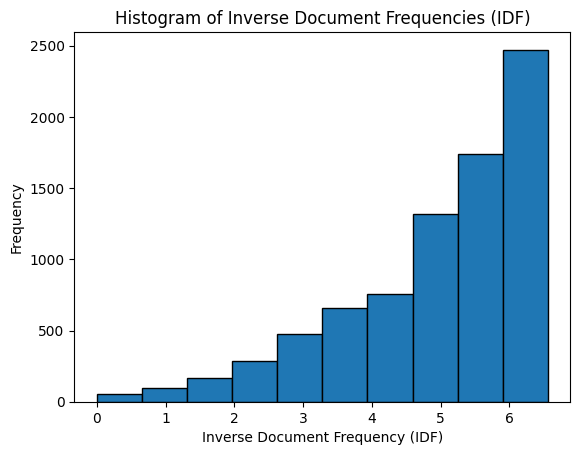

In [25]:
import matplotlib.pyplot as plt
idf_values = list(idf.values())

# Plotting the histogram
plt.hist(idf_values, bins=10, edgecolor='black')
plt.title("Histogram of Inverse Document Frequencies (IDF)")
plt.xlabel("Inverse Document Frequency (IDF)")
plt.ylabel("Frequency")
plt.show()

In [26]:
threshold = np.percentile(idf_values, 0.10)
for word, val in idf.items():
    if val <= threshold:
        print(f'{word}: {val}')

มี: 0.10756628305601612
มาตรา: 0.07345444854915299
ให้: 0.08572454114096734

: 0.0
และ: 0.08264287460355937
ที่: 0.04786990784851432
ใน: 0.07650788603604342
ของ: 0.1091448153490658
การ: 0.08418252078915214


In [27]:
from langchain_community.embeddings import SentenceTransformerEmbeddings
#reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)
def load_embedding_model(embedding_model_name="/project/lt200301-edubot/Capstone-TamTanai/models/multilingual-e5-large"):

    if torch.cuda.is_available():
        device_type = "cuda"
    # elif torch.backends.mps.is_available():
    #     device_type = "mps"
    else:
        device_type = "cpu"
    #embeddings = SentenceTransformerEmbeddings(model_name="infloat/multilingual-e5-large-instruct", model_kwargs={"trust_remote_code":True})
    embeddings = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        model_kwargs={"device": device_type}
    )
    return embeddings

def embed_database(
    documents,
    persist_directory,
    embedding_model_name="/project/lt200301-edubot/Capstone-TamTanai/models/multilingual-e5-large",
    vector_store="faiss",
):

    embeddings = load_embedding_model(embedding_model_name)

    # Embedding temp exists
    if os.path.isdir(persist_directory):
        if vector_store == "faiss":
            vectordb = FAISS.load_local(
                persist_directory, embeddings,allow_dangerous_deserialization=True
            )
        elif vector_store == "chroma":
            vectordb = Chroma(
                embedding_function=embeddings, persist_directory=persist_directory
            )
            vectordb.persist()
        else:
            raise NotImplementedError(
                f"Embedding Algorithm {vector_store} is not supported/implemented"
            )

    # Create embeddings if not exists
    else:
        if vector_store == "faiss":
            vectordb = FAISS.from_documents(
                documents=documents,
                embedding=embeddings
            )
            vectordb.save_local(persist_directory)
        elif vector_store == "chroma":
            vectordb = Chroma.from_documents(
                documents=documents,
                embedding=embeddings,
                persist_directory=persist_directory,
            )
            vectordb.persist()
        else:
            raise NotImplementedError(
                f"Embedding Algorithm {vector_store} is not supported/implemented"
            )

    return vectordb

def reranker(question,doc):
    reranker = FlagReranker('BAAI/bge-reranker-large', use_fp16=True)
    check = []
    for i in range (len(doc)) :
        check.append([question,doc[i].page_content])
    score = reranker.compute_score(check)
    return doc[score.index(max(score))].page_content

In [28]:
persist_directory = "./vectordb"
vectordb = embed_database(documents=documents, persist_directory=persist_directory)
question = "ขอดูอย่างคดีที่มีการพิพากษาของศาลฎีกาต่างจากศาลอุทธรณ์หน่อยได้ไหมครับ"
# retriever= vectordb.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5})
# retrieved_docs = retriever.get_relevant_documents(question)
# print(len(retrieved_docs))

/tmp/ipykernel_3472/2102720737.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(


In [29]:
from pythainlp import word_tokenize, pos_tag
from pythainlp.corpus.common import thai_stopwords
import nltk
from nltk.corpus import stopwords


if os.name != "nt":
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
# %% [markdown]
###**setup var**

#%%
#chunk_size = 2000
# chunk_overlap = 200
# embedding_algorithm = "faiss"
# source_directory = f"{root_dir}/ir-service/docs"
# persist_directory = f"{root_dir}/ir-service/tmp/embeddings/{embedding_algorithm}"
# print(root_dir)
# print(persist_directory)

# Original mapper dictionary
mapper = {
    "law_doc-84-89.txt": "761/2566",
    "law_doc-44-46.txt": "1301/2566",
    "law_doc-54-57.txt": "1225/2566",
    "law_doc-12-13.txt": "2525/2566",
    "law_doc-40-43.txt": "1305/2566",
    "law_doc-14-15.txt": "2085/2566",
    "law_doc-64-69.txt": "1090/2566",
    "law_doc-1-5.txt": "2610/2566",
    "law_doc-78-81.txt": "882/2566",
    "law_doc-82-83.txt": "835/2566",
    "law_doc-35-39.txt": "1306/2566",
    "law_doc-16-20.txt": "1574/2566",
    "law_doc-32-34.txt": "1373/2566",
    "law_doc-74-77.txt": "934/2566",
    "law_doc-6-11.txt": "2609/2566",
    "law_doc-90-92.txt": "756/2566",
    "law_doc-47-53.txt": "1300/2566",
    "law_doc-58-63.txt": "1101/2566",
    "law_doc-70-73.txt": "1003/2566",
    "law_doc-21-31.txt": "1542/2566",
}

# Reverse the mapping and format it
mapper_reverse = {f"คดี {case}": filename for filename, case in mapper.items()}

endl = "\n"
# print(root_dir)
exclude_pattern = re.compile(r"[^ก-๙]+")  # |[^0-9a-zA-Z]+


def is_exclude(text):
    return bool(exclude_pattern.search(text))


key_tags = ["NCMN", "NCNM", "NPRP", "NONM", "NLBL", "NTTL"]

thaistopwords = list(thai_stopwords())
nltk.download("stopwords")


def remove_stopwords(text):
    res = [
        word.lower()
        for word in text
        if (word not in thaistopwords and word not in stopwords.words())
    ]
    return res


def keyword_search(question, idf):
    tokens = word_tokenize(question, engine="newmm", keep_whitespace=False)
    pos_tags = pos_tag(tokens)
    noun_pos_tags = []
    for e in pos_tags:
        if e[1] in key_tags:
            noun_pos_tags.append(e[0])
    noun_pos_tags = remove_stopwords(noun_pos_tags)
    if idf:
        noun_pos_tags = [word for word in noun_pos_tags if word != 'มาตรา' or 'มาตรา' not in word]
    noun_pos_tags = list(set(noun_pos_tags))
    return noun_pos_tags


# %%
def find_case_number(text):
    pattern = re.compile(r"(?<!\d)(\d{1,5}/\d{4})(?!\d)")
    match = re.findall(pattern, text)
    if pattern.search(text) and all(e in mapper.values() for e in match):
        return [True, match]
    else:
        return [False, ""]


def keyword_matcher(doc, keywords):
    matched_keywords = []
    for keyword in keywords:
        pattern = re.compile(re.escape(keyword))
        if pattern.search(doc.page_content):
            matched_keywords.append(keyword)
    return matched_keywords


def filter_docs_by_keywords(docs, keywords, question):
    filtered_docs = []
    matches = []
    for doc in docs:
        matched_keywords = []
        if find_case_number(question)[0]:
            case_num = find_case_number(question)[1]
            for num in case_num:
                pattern = re.compile(re.escape(num))
                if pattern.search(doc.page_content):
                    matched_keywords = keyword_matcher(doc, keywords)
                    if len(matched_keywords) >= min(3, len(keywords)):
                        matches.append(matched_keywords)
                        filtered_docs.append(doc)
            continue
        matched_keywords = keyword_matcher(doc, keywords)
        if len(matched_keywords) >= min(2, len(keywords)):
            matches.append(matched_keywords)
            filtered_docs.append(doc)
    return filtered_docs, matches


# %%
def parse_source_docs(source_docs):
    if source_docs is not None:
        results = []
        for res in source_docs:
            if res.metadata["source"].split("/")[-1] in mapper:
                context = f"""คดีหมายเลข {mapper[res.metadata["source"].split("/")[-1]]}\n{res.page_content}"""
                results.append(context)
            else:
                results.append(res.page_content)
        # srcs = [f"""<<<{res.metadata["source"].split("/")[-1]}>>>\n<<<case #{mapper[res.metadata["source"].split("/")[-1]]}>>>\n{res.page_content}""" for res in source_docs]
        result = "\n\n".join(results)
        return result
    else:
        return []


def parse_matched_keywords(matched_keywords):
    if matched_keywords is not None:
        result = "\n".join(str(keyword) + "," for keyword in matched_keywords)
    else:
        result = []
    return result


def retriever(question, documents, vector_database, idf=False):
    global co
    try:
        if question in ["", "-", None]:
            raise Exception("No question")
        ti = time.time()
    
        # keywords search
        keywords = keyword_search(question, idf)
        keywords_filtered_docs, matched_keywords = filter_docs_by_keywords(
            documents, keywords, question
        )
        #if len(keywords_filtered_docs) == 0:
           # return {
             #   "time": 0,
            #    "question": question,
             #   "reranked_docs": "",
           # }
    
        # context search
        retrieved_docs = []
        if not find_case_number(question)[0]:
          retriever= vector_database.as_retriever(search_type="similarity", search_kwargs={"score_threshold": 0.6})
          retrieved_docs = retriever.get_relevant_documents(question)
        #if len(retrieved_docs) == 0: return []
        #else : return retrieved_docs
            #return {
            #    "time": tf - ti,
            #    "question": question,
            #    "reranked_docs": "",
           # }
    
        # rerank
        relevant_src_docs = keywords_filtered_docs + retrieved_docs
        if len(relevant_src_docs) == 0 : return []
        else : return relevant_src_docs
        #max_relevant_doc = reranker(question,relevant_src_docs)
        #return max_relevant_doc
        if len(relevant_src_docs) == 0:
            return {
                "time": tf - ti,
                "question": question,
                "reranked_docs": "",
            }
        relevant_docs = [doc.page_content for doc in relevant_src_docs]
        if co is None:
            co = cohere.Client(os.getenv("COHERE"))
        rerank_hits = co.rerank(
            query=question,
            documents=relevant_docs,
            model="rerank-multilingual-v2.0",
            top_n=1,
        )
        results = [relevant_src_docs[hit.index] for hit in rerank_hits.results]
        parse_reranked_docs = parse_source_docs(results)
        tf = time.time()
    
        del keywords, keywords_filtered_docs, matched_keywords, retrieved_docs, relevant_src_docs, relevant_docs, rerank_hits, results
    
        # return f"""> Time: {tf-ti}\n\n> Question: {question}\n\n> Answer: {result}\n\n> Source docs:\n{relevant_source_docs}"""
        return {
            "time": tf - ti,
            "question": question,
            "reranked_docs": parse_reranked_docs,
        }
    except Exception as e:
        print(f"{question} @{e}")
        return {
            "error": str(e),
            "source_doc": [],
            "response": "",
            "time": "",
            "source": "",
        }

[nltk_data] Error loading stopwords: <urlopen error [Errno 101]
[nltk_data]     Network is unreachable>


In [34]:
question = "ขอดูอย่างคดีที่มีการพิพากษาของศาลฎีกาต่างจากศาลอุทธรณ์หน่อยได้ไหมครับ"
len(retriever(question, documents, vectordb))

78

In [6]:
import pandas as pd
pd.read_csv('../asset/dataset/testdata.csv')

,question,answer,knowledges,prompt
0,ตามพระราชบัญญัติขายตรงและตลาดแบบตรง พ.ศ. 2545 ...,'สินค้า' หมายความว่า สิ่งของที่ผลิตหรือมีไว้เพ...,พระราชบัญญัติขายตรงและตลาดแบบตรง พ.ศ. 2545\n\n...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
1,หากลูกหนี้ไม่ได้กำหนดเวลาชำระหนี้ไว้ ลูกหนี้สา...,ลูกหนี้สามารถชำระหนี้ได้โดยพลัน,ประมวลกฎหมายแพ่งและพาณิชย์ - บรรพ 2 (หนี้) - ล...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
2,เครื่องหมายการค้าที่จดทะเบียนไว้ตามกฎหมายเดิมจ...,เครื่องหมายการค้าที่จดทะเบียนไว้ตามพระราชบัญญั...,พระราชบัญญัติเครื่องหมายการค้า (ฉบับที่ 3) พ.ศ...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
3,หากลูกหนี้ได้ชำระหนี้สินเต็มจำนวนแล้ว ศาลมีอำน...,ศาลมีอำนาจสั่งยกเลิกการล้มละลายหากหนี้สินของบุ...,พระราชบัญญัติล้มละลาย (ฉบับที่ 10) พ.ศ. 2561 -...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
4,บัตรอิเล็กทรอนิกส์ตามนิยามในประมวลกฎหมายอาญาหม...,บัตรอิเล็กทรอนิกส์หมายถึงเอกสารหรือวัตถุอื่นใด...,ประมวลกฎหมายอาญา - ภาค 1 (บทบัญญัติทัว่ไป) - ล...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
...,...,...,...,...
408,สถานศึกษา สถานฝึกและอบรม และสถานแนะนำทางจิตที่...,จะเป็นสถานศึกษา สถานฝึกและอบรม และสถานแนะนำทาง...,พระราชบัญญัติศาลเยาวชนและครอบครัวและวิธีพิจารณ...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
409,หากผู้ทำแผนไม่สามารถมาประชุมได้เพราะเหตุผลพิเศ...,หากผู้ทำแผนไม่สามารถมาประชุมได้เพราะเหตุผลพิเศ...,พระราชบัญญัติล้มละลาย (ฉบับที่ 10) พ.ศ. 2561 -...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
410,หากบุคคลใดกรอกข้อมูลเท็จลงในแบบสำรวจ จะต้องรับ...,บุคคลดังกล่าวจะต้องระวางโทษจำคุกไม่เกินหกเดือน...,พระราชบัญญัติประกันสังคม พ.ศ. 2533 (ฉบับปรับปร...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...
411,กรรมการค่าจ้างมีวาระการดำรงตำแหน่งกี่ปี?,กรรมการค่าจ้างมีวาระการดำรงตำแหน่งคราวละสองปี,พระราชบัญญัติคุ้มครองแรงงาน (ฉบับที่ 8) พ.ศ. 2...,<s><|im_start|>system\nคุณคือนักกฎหมายที่จะตอบ...


In [35]:
df = pd.read_csv('../asset/dataset/dataset.csv')
df

,question,answer,references,source,knowledges
0,ศาลมีอำนาจใดในการพิจารณาคดีเกี่ยวกับยาเสพติดตา...,ศาลมีอำนาจพิจารณาพิพากษาคดีโดยคำนึงถึงการสงเคร...,มาตรา 165 ของประมวลกฎหมายยาเสพติด,_ตรวจแล้ว/ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเ...,ประมวลกฎหมายยาเสพติด - ภาค 3 (บทกำหนดโทษ) - ลั...
1,เมื่อไหร่ที่สมาคมนายจ้างจะถือว่าเลิก,สมาคมนายจ้างย่อมเลิกด้วยเหตุใดเหตุหนึ่ง ดังต่อ...,มาตรา 82,_ตรวจแล้ว/พระราชบัญญัติแรงงานสัมพันธ์/พระราชบั...,พระราชบัญญัติแรงงานสัมพันธ์ (ฉบับที่ 3) พ.ศ. 2...
2,การยื่นอุทธรณ์ต้องทำภายในกี่เดือนหลังจากอ่านหร...,ต้องยื่นต่อศาลชั้นต้นในกำหนดหนึ่งเดือน,มาตรา 198 ของประมวลกฎหมายวิธีพิจารณาความอาญา,_ตรวจแล้ว/ประมวลกฎหมายวิธีพิจารณาความอาญา/ประม...,ประมวลกฎหมายวิธีพิจารณาความอาญา - ภาค 4 (อุทธร...
3,ศาลมีอำนาจใดบ้างเกี่ยวกับการรับฟังพยานหลักฐาน?,ศาลมีอำนาจปฏิเสธไม่รับพยานหลักฐานที่รับฟังไม่ไ...,อ้างอิงจากมาตรา 86 ของประมวลกฎหมายวิธีพิจารณาค...,_ตรวจแล้ว/ประมวลกฎหมายวิธีพิจารณาความแพ่ง/ประม...,ประมวลกฎหมายวิธีพิจารณาความแพ่ง - ภาค 1 (บททั่...
4,หากผู้เช่านาต้องการอุทธรณ์คำวินิจฉัยของคณะกรรม...,ผู้เช่านาต้องทำเป็นหนังสือยื่นต่อประธานคณะกรรม...,อ้างอิงจากมาตรา 56 ของพระราชบัญญัติการเช่าที่ด...,_ตรวจแล้ว/พระราชบัญญัติการเช่าที่ดินเพื่อเกษตร...,พระราชบัญญัติการเช่าที่ดินเพื่อเกษตรกรรม พ.ศ. ...
...,...,...,...,...,...
4116,เมื่อเจ้าหน้าที่ของรัฐพบว่ามีการกระทำความผิดทา...,เจ้าหน้าที่ของรัฐจะต้องดำเนินการแสวงหาข้อเท็จจ...,มาตรา 19 และ 20 ของพระราชบัญญัติว่าด้วยการปรับ...,_ตรวจแล้ว/พระราชบัญญัติว่าด้วยการปรับเป็นพินัย...,พระราชบัญญัติว่าด้วยการปรับเป็นพินัย พ.ศ. 2565...
4117,ข้อพิพาทแรงงานหมายถึงอะไรตามพระราชบัญญัติแรงงา...,หมายถึงข้อขัดแย้งระหว่างนายจ้างกับลูกจ้างเกี่ย...,มาตรา 5 ของพระราชบัญญัติแรงงานสัมพันธ์ พ.ศ. 2518,_ตรวจแล้ว/พระราชบัญญัติแรงงานสัมพันธ์/พระราชบั...,พระราชบัญญัติแรงงานสัมพันธ์ พ.ศ. 2518\n\nมาตรา...
4118,หากกรรมการผู้แทนองค์กรลูกจ้างหรือกรรมการผู้ทรง...,"ใช่, จะถูกพ้นจากตำแหน่งหากรัฐมนตรีให้ออกเพราะบ...",มาตรา 20 ของพระราชกำหนดการบริหารจัดการการทำงาน...,_ตรวจแล้ว/พระราชกำหนดการบริหารจัดการการทำงานขอ...,พระราชกำหนดการบริหารจัดการการทำงานของคนต่างด้า...
4119,เมื่อหนี้และสิทธิในการรับหนี้ตกอยู่กับบุคคลเดี...,ตามมาตรา 353 ของประมวลกฎหมายแพ่งและพาณิชย์ หนี...,อ้างอิงจากมาตรา 353 ของประมวลกฎหมายแพ่งและพาณิชย์,_ตรวจแล้ว/ประมวลกฎหมายแพ่งและพาณิชย์/ประมวลกฎห...,ประมวลกฎหมายแพ่งและพาณิชย์ - บรรพ 2 (หนี้) - ล...


In [36]:
retrieved_documents = retriever(df.iloc[0]['question'], documents, vectordb)

In [37]:
retrieved_documents[0].metadata['source']

'/home/shanwibo/Capstone-TamTanai/asset/documentation/พระราชบัญญัติว่าด้วยการปรับเป็นพินัย/พระราชบัญญัติว่าด้วยการปรับเป็นพินัย_บทนำ.txt'

In [38]:
df.iloc[0]['source']

'_ตรวจแล้ว/ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค3_ลักษณะ7.txt'

In [39]:
for retrieved_document in retrieved_documents:
    if 'ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค3_ลักษณะ7.txt' in retrieved_document.metadata['source']:
        print(retrieved_document.metadata['source'])

/home/shanwibo/Capstone-TamTanai/asset/documentation/ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค3_ลักษณะ7.txt
/home/shanwibo/Capstone-TamTanai/asset/documentation/ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค3_ลักษณะ7.txt


In [97]:
hits = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    hit = False
    retrieved_documents = retriever(row['question'], documents, vectordb)
    for retrieved_document in retrieved_documents:
        if '/'.join(row['source'].split('/')[1:]) in retrieved_document.metadata['source']:
            hit = True
            break
    hits.append(hit)

100%|██████████| 4121/4121 [03:56<00:00, 17.45it/s]


# Recall

In [98]:
sum(hits) / len(hits)

0.9956321281242417

# Reranker

In [1]:
from FlagEmbedding import FlagReranker
reranker = FlagReranker('/project/lt200301-edubot/Capstone-TamTanai/models/bge-reranker-v2-m3', use_fp16=True)

/home/shanwibo/.conda/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------using 4*GPUs----------


In [ ]:
pairs = [["中国的首都在哪儿","北京"], ["what is the capital of China?", "北京"], ["how to implement quick sort in python?","Introduction of quick sort"]]

In [5]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name_or_path = '/project/lt200301-edubot/Capstone-TamTanai/models/gte-multilingual-reranker-base'
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path, trust_remote_code=True,
    torch_dtype=torch.float16
)
model.eval()

NewForSequenceClassification(
  (new): NewModel(
    (embeddings): NewEmbeddings(
      (word_embeddings): Embedding(250048, 768, padding_idx=1)
      (rotary_emb): NTKScalingRotaryEmbedding()
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): NewEncoder(
      (layer): ModuleList(
        (0-11): 12 x NewLayer(
          (attention): NewSdpaAttention(
            (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (mlp): NewGatedMLP(
            (up_gate_proj): Linear(in_features=768, out_features=6144, bias=False)
            (down_proj): Linear(in_features=3072, out_features=768, bias=True)
            (act_fn): GELUActivation()
            (hidden_dropout): Dropout(p=0.1, inplace=Fals

In [21]:
[["中国的首都在哪儿","北京"]]*2

[['中国的首都在哪儿', '北京'], ['中国的首都在哪儿', '北京']]

In [27]:
pairs = [["中国的首都在哪儿","北京"]]*100
with torch.no_grad():
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    scores = model(**inputs, return_dict=True).logits.view(-1, ).float().numpy()
np.argmax(scores)

0

In [153]:
reranked_hits = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    hit = False
    retrieved_documents = retriever(row['question'], documents, vectordb)
    scores = reranker.compute_score([[row['question'], retrieved_document.page_content ] for retrieved_document in retrieved_documents], normalize=True)
    idx = np.argmax(scores)
    retrieved_document = retrieved_documents[idx]
    if '/'.join(row['source'].split('/')[1:]) in retrieved_document.metadata['source']:
        hit = True
    reranked_hits.append(hit)

100%|██████████| 4121/4121 [28:48<00:00,  2.38it/s]


## Accuracy

In [154]:
sum(reranked_hits) / len(reranked_hits)

0.6833292890075224

# IDF

In [40]:
threshold = np.percentile(idf_values, 0.10)
for word, val in idf.items():
    if val <= threshold:
        print(f'{word}: {val}')

มี: 0.10756628305601612
มาตรา: 0.07345444854915299
ให้: 0.08572454114096734

: 0.0
และ: 0.08264287460355937
ที่: 0.04786990784851432
ใน: 0.07650788603604342
ของ: 0.1091448153490658
การ: 0.08418252078915214


In [41]:
threshold = np.percentile(idf_values, 0.10)
for word, val in idf.items():
    if val <= threshold and word not in list(thai_stopwords()):
        print(f'{word}: {val}')

มาตรา: 0.07345444854915299

: 0.0


In [ ]:
hits = []
reranked_hits = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    hit = False
    retrieved_documents = retriever(row['question'], documents, vectordb, idf=True)
    for retrieved_document in retrieved_documents:
        if '/'.join(row['source'].split('/')[1:]) in retrieved_document.metadata['source']:
            hit = True
            break
    hits.append(hit)

    reranked_hit = False
    scores = reranker.compute_score([[row['question'], retrieved_document.page_content] for retrieved_document in retrieved_documents], normalize=True)
    idx = np.argmax(scores)
    retrieved_document = retrieved_documents[idx]
    if '/'.join(row['source'].split('/')[1:]) in retrieved_document.metadata['source']:
        reranked_hit = True
    reranked_hits.append(reranked_hit)

In [45]:
sum(hits) / len(hits)

0.9946614899296288

In [46]:
sum(reranked_hits) / len(reranked_hits)

0.6840572676534822

In [180]:
retrieved_documents = retriever('ศาลมีอำนาจใดในการพิจารณาคดีเกี่ยวกับยาเสพติดตามมาตรา 165?', documents, vectordb, idf=True)
scores = reranker.compute_score([['ศาลมีอำนาจใดในการพิจารณาคดีเกี่ยวกับยาเสพติดตามมาตรา 165?', retrieved_document.page_content ] for retrieved_document in retrieved_documents], normalize=True)
idx = np.argmax(scores)

Compute Scores: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


In [181]:
idx

138

In [182]:
retrieved_documents[idx]

Document(metadata={'source': '/home/shanwibo/Capstone-TamTanai/asset/documentation/ประมวลกฎหมายยาเสพติด/ประมวลกฎหมายยาเสพติด_ภาค3_ลักษณะ7.txt', 'category': 'general'}, page_content='ประมวลกฎหมายยาเสพติด - ภาค 3 (บทกำหนดโทษ) - ลักษณะ 7 (บทกำหนดโทษเกี่ยวกับการเสพยาเสพติดและการมีไว้ในครอบครองซึ่งยาเสพติดเพื่อเสพ)\n\nมาตรา 162  ผู้ใดเสพยาเสพติดให้โทษในประเภท 1 ประเภท 2 หรือประเภท 5 หรือเสพวัตถุออกฤทธิ์ในประเภท 1 หรือประเภท 2 และมิใช่กรณีตามมาตรา 113 หรือมาตรา 114 อันเป็นการฝ่าฝืนมาตรา 104 ต้องระวางโทษจำคุกไม่เกินหนึ่งปี หรือปรับไม่เกินสองหมื่นบาท หรือทั้งจำทั้งปรับ\n\nมาตรา 163  ผู้ใดเสพสารระเหย อันเป็นการฝ่าฝืนมาตรา 105 ต้องระวางโทษจำคุกไม่เกินหนึ่งปี หรือปรับไม่เกินสองหมื่นบาท หรือทั้งจำทั้งปรับ\n\nมาตรา 164  ผู้ใดมีไว้ในครอบครองซึ่งยาเสพติดให้โทษในประเภท 1 ประเภท 2 หรือประเภท 5 หรือวัตถุออกฤทธิ์ในประเภท 1 หรือประเภท 2 เพื่อเสพ อันเป็นการฝ่าฝืนมาตรา 107 ต้องระวางโทษจำคุกไม่เกินสองปี หรือปรับไม่เกินสี่หมื่นบาท หรือทั้งจำทั้งปรับ\n\nมาตรา 165  ในการพิจารณาและพิพากษาคดีตามลักษณะนี้ ให้ศาลมี

In [177]:
len(retriever('ศาลมีอำนาจใดในการพิจารณาคดีเกี่ยวกับยาเสพติดตามมาตรา 165?', documents, vectordb))

506

In [179]:
len(retriever('ศาลมีอำนาจใดในการพิจารณาคดีเกี่ยวกับยาเสพติดตามมาตรา 165?', documents, vectordb, idf=True))

246